In [213]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from skimage import io

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [214]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [215]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter=";")

    expected = list(read_tsv)[0]
    
    return expected

In [216]:
# train
expected_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')
in_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')

# val
expected_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')
in_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')

# test
expected_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/expected.tsv')
in_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [217]:
def show_random_img_with_all_annotations(in_list, expected_list, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(in_list))
        file_name = in_list[random_img]
        print(file_name)

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        annotations = expected_list[random_img].split(' ')
        for i in range(len(annotations)):
            bbox = annotations[i].split('/')[1]
            x0 = int(bbox.split(',')[0])
            y0 = int(bbox.split(',')[1])
            width = int(bbox.split(',')[2])
            height = int(bbox.split(',')[3])
            cat_id = int(annotations[i].split('/')[0])
            rect = matplotlib.patches.Rectangle(
                (x0, y0), 
                width, 
                height, 
                linewidth=1, 
                edgecolor=matplotlib_colours_list[cat_id], 
                facecolor='none'
            )
                
            ax.add_patch(rect)           
            ax.text(
                x0, 
                y0, 
                cat_id, 
                fontsize=8,
                backgroundcolor='black',
                color=matplotlib_colours_list[cat_id]
            )

        plt.show()

354.jpg


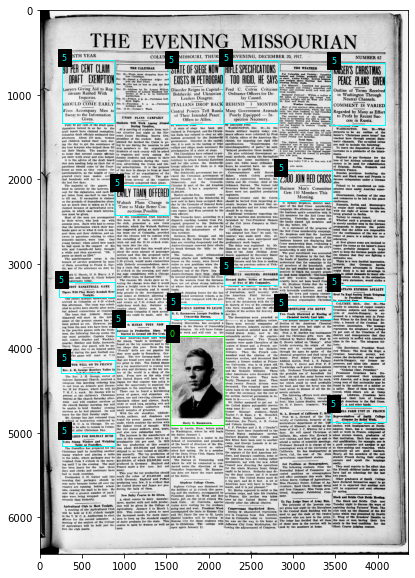

2573.jpg


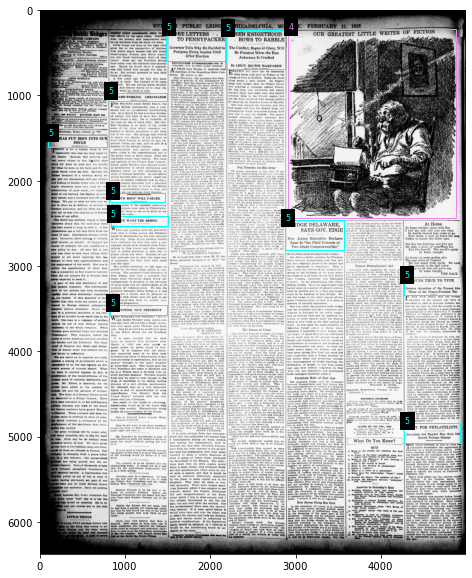

1523.jpg


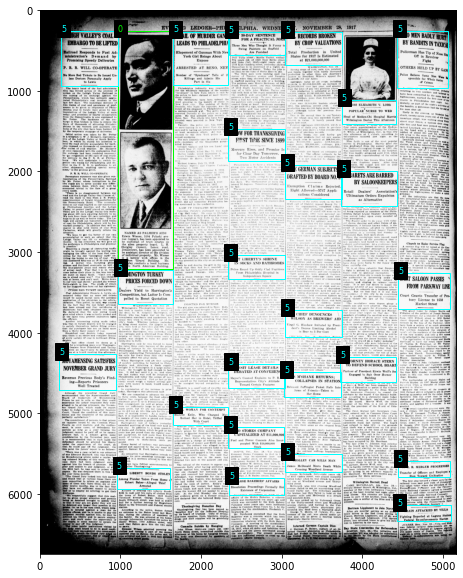

903.jpg


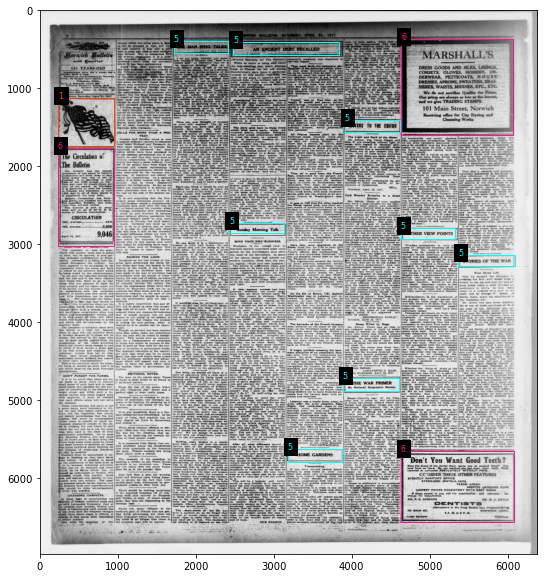

2562.jpg


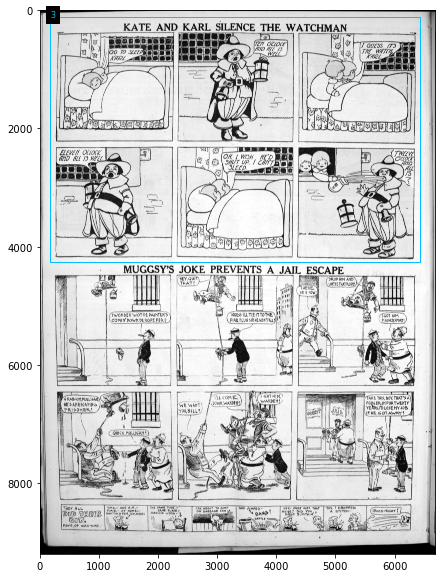

In [233]:
# some random images with annotations
show_random_img_with_all_annotations(
    in_train,
    expected_train,
    DIR_PATH+'scraped_photos_final/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [234]:
class NewspapersDataset(Dataset):
    def __init__(self, img_dir, in_list, expected_list, transform=None, scale=None):
        # selfs
        self.img_dir = img_dir
        self.transform = transform
        self.in_list = in_list
        self.expected_list = expected_list
        self.scale = scale
        
        # read gonito format files
        self.df = pd.DataFrame()
        for i in range(len(self.in_list)):
            if self.scale:
                img_width, img_height = get_image_size.get_image_size(
                    img_dir+self.in_list[i]
                )
                scaler_w = scale[0]/img_width
                scaler_h = scale[1]/img_height
            else:
                scaler_w, scaler_h = 1, 1
            expected_list_split = self.expected_list[i].split(' ')
            for ii in range(len(expected_list_split)):
                expected_list_split_2 = expected_list_split[ii].split('/')
                bbox = expected_list_split_2[1].split(',')
                temp_dict = {
                    'file_name': self.in_list[i],
                    'class': expected_list_split_2[0],
                    'x0': int(bbox[0])*scaler_w,
                    'y0': int(bbox[1])*scaler_h,
                    'x1': int(bbox[0])+int(bbox[2])*scaler_w,
                    'y1': int(bbox[1])+int(bbox[3])*scaler_h,
                }
                self.df = self.df.append(temp_dict, ignore_index=True)
    
    def __len__(self):
        return len(self.expected_list)
    
    def __getitem__(self, index):
        # read images
        img_path = os.path.join(self.img_dir, self.df.iloc[index, 0])
        image = Image.open(img_path)

        # get bbox and area
        bbox = [self.df.x0[index], self.df.y0[index], self.df.x1[index], self.df.y1[index]]
        area = (self.df.y1[index]-self.df.y0[index])*(self.df.x1[index]-self.df.x0[index])
             
        # transformation to tensors
        bbox = torch.as_tensor(bbox, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        label = torch.tensor(int(self.df.iloc[index, 1]))
        
        target = {}
        target["boxes"] = bbox
        target["labels"] = label
        target["image_id"] = index+1 
        target["area"] = area
        
        # data transformation
        if self.transform:            
            image = self.transform(image)
        
        return (image, target)

In [235]:
# hyperparameters
IN_CHANNEL = 1 
NUM_CLASSES = 7
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_EPOCHS = 1
RESIZE = [600, 700]

device = torch.device("cpu")

In [236]:
# load datasets
image_dir = DIR_PATH + 'scraped_photos_final/'
data_transform = transforms.Compose(
    [
        transforms.Resize(RESIZE),
        transforms.Grayscale(num_output_channels=IN_CHANNEL),
        transforms.ToTensor(),
    ]
)

train_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_train, 
        expected_train,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

val_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_val, 
        expected_val,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

test_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_test, 
        expected_test,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

In [27]:
# pre-trained model
backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)

backbone.out_channels = 1280

In [28]:
# loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    backbone.parameters(), 
    lr=LEARNING_RATE
)

In [29]:
# main model
model = FasterRCNN(
    backbone,
    num_classes=NUM_CLASSES,
)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0